## Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import glob, os, pickle

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import copy
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

os.chdir('/workspace/Alzheimer/MOCAE_Base-master/MOC-AE_Code')
from dataset.dataset_alzheimer import *
from utils.metrics import *
from models.dl_blocks import *

In [3]:
with open('/workspace/Alzheimer/MOCAE_Base-master/MOC-AE_Code/config.json', 'r') as f:
    config = json.load(f)

In [4]:
LABELS = sorted(config["alzheimer"]["label_names"], key=config["alzheimer"]["label_names"].get)
LABELS

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


## Load from pickle

In [6]:
data = Dataset(config)

with open(config["PATHS"]["IMAGES_PATH"] + "data_alzheimer_4labels.pkl", 'rb') as f:
    data = pickle.load(f)

In [ ]:
print(f'X_train shape: {np.shape(data.X_train)}, y_train shape: {np.shape(data.y_train)}')
print(f'X_val shape: {np.shape(data.X_val)}, y_val shape: {np.shape(data.y_val)}')

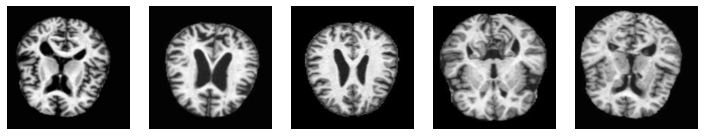

In [8]:
n_images = 5

fig, axes = plt.subplots(1, n_images, figsize=(n_images * 2, 2))

for i in range(n_images):
    img = data.X_train[i].squeeze()  
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')  

plt.tight_layout()
plt.show()

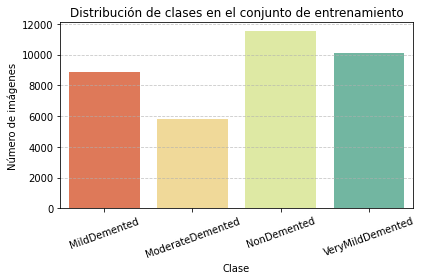

In [22]:
y_train = data.y_train

if len(y_train.shape) > 1:
    y_train = y_train.argmax(axis=1)

label_map = {
    0: "MildDemented",      
    1: "ModerateDemented",     
    2: "NonDemented",      
    3: "VeryMildDemented"    
}

labels_text = pd.Series(y_train).map(label_map)

df = pd.DataFrame({'Etiqueta': labels_text})

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Etiqueta', palette='Spectral', order=sorted(label_map.values()))

plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Clase")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Label variation

In [7]:
y_train = np.copy(data.y_train)
y_train_modified = np.copy(y_train)

num_classes = y_train.shape[1]
num_samples = len(y_train)
noise_ratio = 0.5
num_noisy = int(num_samples * noise_ratio)

np.random.seed(42)
indices_to_modify = np.random.choice(num_samples, size=num_noisy, replace=False)

for idx in indices_to_modify:
    original_label = np.argmax(y_train_modified[idx])
    new_label = random.choice([i for i in range(num_classes) if i != original_label])
    y_train_modified[idx] = np.zeros(num_classes)
    y_train_modified[idx][new_label] = 1.0

In [8]:
data_noisy = copy.copy(data)
data_noisy.y_train = y_train_modified

In [29]:
print(f'X_train shape: {np.shape(data_noisy.X_train)}, y_train shape: {np.shape(data_noisy.y_train)}')
print(f'X_val shape: {np.shape(data_noisy.X_val)}, y_val shape: {np.shape(data_noisy.y_val)}')

X_train shape: (36346, 224, 224, 1), y_train shape: (36346, 4)
X_val shape: (4038, 224, 224, 1), y_val shape: (4038, 4)


In [30]:
print("¿y_train == y_train_modified?", np.array_equal(data.y_train, data_noisy.y_train))  
print("¿X_train se mantiene igual?", np.array_equal(data.X_train, data_noisy.X_train))  

¿y_train == y_train_modified? False
¿X_train se mantiene igual? True


In [31]:
original_classes = np.argmax(data.y_train, axis=1)
modified_classes = np.argmax(data_noisy.y_train, axis=1)
num_changed = np.sum(original_classes != modified_classes)

print(f"Etiquetas modificadas en data_noisy: {num_changed} / {num_samples} ({100 * num_changed / num_samples:.2f}%)")

Etiquetas modificadas en data_noisy: 10903 / 36346 (30.00%)


## Evaluation functions

In [5]:
def plot_train_val(history, complementary_metric="accuracy"):
    # X axis definition
    x_axis = range(len(history['loss']))

    # Define figure
    plt.rcParams['figure.figsize'] = [20, 5]
    f, ax = plt.subplots(1, 2, sharex=False, sharey=False)

    # Plot complete loss figure
    ax[0].plot(x_axis, history['loss'], label='Train Loss')
    ax[0].plot(x_axis, history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('iteration')
    ax[0].legend(loc="upper right")
    ax[0].grid()
    
    ax[1].plot(x_axis, history[complementary_metric], label='Train '+complementary_metric)
    ax[1].plot(x_axis, history['val_'+complementary_metric], label='Validation '+complementary_metric)
    ax[1].set_title(complementary_metric)
    ax[1].set_xlabel('iteration')
    ax[1].legend(loc="upper right")
    ax[1].grid()
    
    # Save figure
    plt.show()

In [6]:
def plot_conf_mat(y_pred, y_val, names):
    f, ax = plt.subplots(1, figsize=(5, 5))

    sns.heatmap(confusion_matrix(y_val, y_pred), annot=True,
                cmap='Blues', fmt = 'd', ax=ax, cbar=False)

    ax.set_ylabel("Real label")
    ax.set_xlabel("Predicted label")
    
    names = [os.path.basename(path) for path in names]
    
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax.xaxis.set_ticklabels(names)
    ax.set_yticklabels(ax.get_yticks(), rotation = 45)
    ax.yaxis.set_ticklabels(names)

    plt.show()

    print(classification_report(y_val, y_pred))

## Train configuration

In [9]:
batch_size = 64
epochs = 10
val_perc = 0.1

In [10]:
n_imgs = 1000
n_it = 10

## Results with 10 iterations

In [27]:
base_path = '/workspace/Alzheimer/MOCAE_Base-master/results_training/'

### Classifier

In [9]:
model_path = os.path.join(base_path, f'Classifier_1', 'models/')

encoder = load_model(os.path.join(model_path, 'e_best_encoder.h5'), custom_objects={'sampling': sampling})
classifier = load_model(os.path.join(model_path, 'e_best_classifier.h5'), custom_objects={'sampling': sampling})

model = Model(inputs=encoder.input, outputs=classifier(encoder.output))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization_360 (BatchN (None, 224, 224, 1)  4           input_51[0][0]                   
__________________________________________________________________________________________________
re_lu_340 (ReLU)                (None, 224, 224, 1)  0           batch_normalization_360[0][0]    
__________________________________________________________________________________________________
dropout_350 (Dropout)           (None, 224, 224, 1)  0           re_lu_340[0][0]                  
______________________________________________________________________________________________

In [61]:
tf.get_logger().setLevel('ERROR')  

accuracy_classifier = []
f1_score_classifier = []
recall_classifier = []
precision_classifier = []

for i in range(1, n_it + 1):
    model_path = os.path.join(base_path, f'Classifier_{i}', 'models/')

    encoder = load_model(os.path.join(model_path, 'e_best_encoder.h5'), custom_objects={'sampling': sampling})
    classifier = load_model(os.path.join(model_path, 'e_best_classifier.h5'), custom_objects={'sampling': sampling})

    lat_space = encoder.predict(data.X_val[:n_imgs])

    y_real = data.y_val[:n_imgs]
    if len(y_real.shape) > 1:
        y_real = np.argmax(y_real, axis=1)

    y_pred = classifier.predict(lat_space)
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)

    report = classification_report(y_real, y_pred, output_dict=True)
    accuracy_classifier.append(report['accuracy'])
    f1_score_classifier.append(report['macro avg']['f1-score'])
    recall_classifier.append(report['macro avg']['recall'])
    precision_classifier.append(report['macro avg']['precision'])

In [63]:
print("-"*5, 'Classifier', "-"*5)
print("accuracy: " + str(np.mean(accuracy_classifier)))
print("f1_score: " + str(np.mean(f1_score_classifier)))
print("recall: " + str(np.mean(recall_classifier)))
print("precision: " + str(np.mean(precision_classifier)))

----- Classifier -----
accuracy: 0.8924
f1_score: 0.9023070392853653
recall: 0.9024198970348178
precision: 0.9153339580617772


### MOCVAE

In [10]:
model_path = os.path.join(base_path, f'MOCVAE_1', 'models/')

encoder = load_model(os.path.join(model_path, 'e_best_encoder.h5'), custom_objects={'sampling': sampling})
classifier = load_model(os.path.join(model_path, 'e_best_classifier.h5'), custom_objects={'sampling': sampling})

model = Model(inputs=encoder.input, outputs=classifier(encoder.output))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 224, 224, 1)  4           input_4[0][0]                    
__________________________________________________________________________________________________
re_lu_22 (ReLU)                 (None, 224, 224, 1)  0           batch_normalization_24[0][0]     
__________________________________________________________________________________________________
dropout_24 (Dropout)            (None, 224, 224, 1)  0           re_lu_22[0][0]                   
____________________________________________________________________________________________

In [28]:
tf.get_logger().setLevel('ERROR')  

accuracy_mocvae = []
f1_score_mocvae = []
recall_mocvae = []
precision_mocvae = []

confusion_matrices = []

for i in range(1, n_it + 1):
    model_path = os.path.join(base_path, f'MOCVAE_{i}', 'models/')

    encoder = load_model(model_path + 'e_best_encoder.h5', custom_objects={'sampling': sampling})
    classifier = load_model(model_path + 'e_best_classifier.h5', custom_objects={'sampling': sampling})

    lat_space = encoder.predict(data.X_val[:n_imgs])
    z_mean, z_log_sigma, z = lat_space
    lat_space = z  

    y_real = data.y_val[:n_imgs]
    if len(y_real.shape) > 1:
        y_real = np.argmax(y_real, axis=1)

    y_pred = classifier.predict(lat_space)
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)

    report = classification_report(y_real, y_pred, output_dict=True)
    accuracy_mocvae.append(report['accuracy'])
    f1_score_mocvae.append(report['macro avg']['f1-score'])
    recall_mocvae.append(report['macro avg']['recall'])
    precision_mocvae.append(report['macro avg']['precision'])
    
    cm = confusion_matrix(y_real, y_pred)
    confusion_matrices.append(cm)

In [22]:
print("-"*5, 'MOCVAE', "-"*5)
print("accuracy: " + str(np.mean(accuracy_mocvae)))
print("f1_score: " + str(np.mean(f1_score_mocvae)))
print("recall: " + str(np.mean(recall_mocvae)))
print("precision: " + str(np.mean(precision_mocvae)))

----- MOCVAE -----
accuracy: 0.8019000000000001
f1_score: 0.8162438859839284
recall: 0.8196312964972485
precision: 0.8331809555001506


In [29]:
path = '/workspace/Alzheimer/MOCAE_Base-master/confusion_matrix'
os.makedirs(path, exist_ok=True) 

desired_order = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
indices = [data.labels.index(label) for label in desired_order]

def reorder_cm(cm, indices):
    cm = cm[indices, :]
    cm = cm[:, indices]
    return cm

def plot_confusion_matrix(cm, classes, title='Matriz de Confusión', cmap=plt.cm.Blues, filename=None):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha='center', va='center',
                     color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

total = len(confusion_matrices)
random_indices = random.sample(range(total), 4)
for idx in random_indices:
    cm = confusion_matrices[idx]
    cm_ordered = reorder_cm(cm, indices)
    iteracion = idx + 1  
    filename = os.path.join(path, f'confusion_matrix_iteracion_{iteracion}.png')
    plot_confusion_matrix(
        cm_ordered,
        desired_order,
        title=f'Matriz de Confusión Iteración {iteracion}',
        filename=filename
    )

In [ ]:
desired_order = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

indices = [data.labels.index(label) for label in desired_order]

def reorder_cm(cm, indices):
    cm = cm[indices, :]
    cm = cm[:, indices]
    return cm

def plot_confusion_matrix(cm, classes, title='Matriz de Confusión', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha='center', va='center',
                     color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.show()

for i, cm in enumerate(confusion_matrices, start=1):
    cm_ordered = reorder_cm(cm, indices)
    plot_confusion_matrix(cm_ordered, desired_order, title=f'Matriz de Confusión Iteración {i}')

### EfficientNetB0

In [ ]:
accuracy_efficientnet = []
f1_score_efficientnet = []
recall_efficientnet = []
precision_efficientnet = []

for i in range(1,n_it+1):
    print('It:', str(i), datetime.now())
    model_efficientnet = tf.keras.applications.EfficientNetB0(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_efficientnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_efficientnet.fit(np.array(data.X_train), np.array(data.y_train), epochs=epochs, batch_size=batch_size,
                        validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_efficientnet.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_efficientnet.append(report['accuracy'])
    f1_score_efficientnet.append(report['macro avg']['f1-score'])
    recall_efficientnet.append(report['macro avg']['recall'])
    precision_efficientnet.append(report['macro avg']['precision'])
    
    model_path = f'{base_path}/EfficientNetB0/EfficientNetB0_{i}.h5'
    model_efficientnet.save(model_path)
    print(f'Modelo guardado en: {model_path}')

In [64]:
model_dir = os.path.join(base_path, 'EfficientNetB0')

accuracy_efficientnet = []
f1_score_efficientnet = []
recall_efficientnet = []
precision_efficientnet = []

for i in range(1, n_it + 1):
    model_path = os.path.join(model_dir, f'EfficientNetB0_{i}.h5')

    model_efficientnet = tf.keras.models.load_model(model_path)

    y_pred = np.argmax(model_efficientnet.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_efficientnet.append(report['accuracy'])
    f1_score_efficientnet.append(report['macro avg']['f1-score'])
    recall_efficientnet.append(report['macro avg']['recall'])
    precision_efficientnet.append(report['macro avg']['precision'])

In [23]:
print("-"*5, 'EfficientNetB0', "-"*5)
print("accuracy: " + str(np.mean(accuracy_efficientnet)))
print("f1_score: " + str(np.mean(f1_score_efficientnet)))
print("recall: " + str(np.mean(recall_efficientnet)))
print("precision: " + str(np.mean(precision_efficientnet)))

----- EfficientNetB0 -----
accuracy: 0.6740999999999999
f1_score: 0.6820347241166368
recall: 0.6855291653733454
precision: 0.7240566283565263


### DenseNet201

In [ ]:
accuracy_densenet = []
f1_score_densenet = []
recall_densenet = []
precision_densenet = []

for i in range(1,n_it+1):
    print('It:', str(i), datetime.now())
    model_densenet = tf.keras.applications.DenseNet201(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_densenet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_densenet.fit(np.array(data.X_train), np.array(data.y_train), epochs=epochs, batch_size=batch_size,
                        validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_densenet.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_densenet.append(report['accuracy'])
    f1_score_densenet.append(report['macro avg']['f1-score'])
    recall_densenet.append(report['macro avg']['recall'])
    precision_densenet.append(report['macro avg']['precision'])
    
    model_path = f'{base_path}/DenseNet201/DenseNet201_{i}.h5'
    model_densenet.save(model_path)
    print(f'Modelo guardado en: {model_path}')

In [65]:
model_dir = os.path.join(base_path, 'DenseNet201')

accuracy_densenet = []
f1_score_densenet = []
recall_densenet = []
precision_densenet = []

for i in range(1, n_it + 1):
    model_path = os.path.join(model_dir, f'DenseNet201_{i}.h5')

    model_densenet = tf.keras.models.load_model(model_path)

    y_pred = np.argmax(model_densenet.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_densenet.append(report['accuracy'])
    f1_score_densenet.append(report['macro avg']['f1-score'])
    recall_densenet.append(report['macro avg']['recall'])
    precision_densenet.append(report['macro avg']['precision'])

In [27]:
print("-"*5, 'DenseNet201', "-"*5)
print("accuracy: " + str(np.mean(accuracy_densenet)))
print("f1_score: " + str(np.mean(f1_score_densenet)))
print("recall: " + str(np.mean(recall_densenet)))
print("precision: " + str(np.mean(precision_densenet)))

----- DenseNet201 -----
accuracy: 0.6703
f1_score: 0.66475970623199
recall: 0.6953532278620577
precision: 0.7922878747499918


### VGG19

In [ ]:
accuracy_vgg19 = []
f1_score_vgg19 = []
recall_vgg19 = []
precision_vgg19 = []

for i in range(6,n_it+1):
    print('It:', str(i), datetime.now())
    model_vgg19 = tf.keras.applications.VGG19(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_vgg19.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_vgg19.fit(np.array(data.X_train), np.array(data.y_train), epochs=epochs, batch_size=batch_size,
                        validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_vgg19.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_vgg19.append(report['accuracy'])
    f1_score_vgg19.append(report['macro avg']['f1-score'])
    recall_vgg19.append(report['macro avg']['recall'])
    precision_vgg19.append(report['macro avg']['precision'])
    
    model_path = f'{base_path}/VGG19/VGG19_{i}.h5'
    model_vgg19.save(model_path)
    print(f'Modelo guardado en: {model_path}')

In [61]:
model_dir = os.path.join(base_path, 'VGG19')

accuracy_vgg19 = []
f1_score_vgg19 = []
recall_vgg19 = []
precision_vgg19 = []

for i in range(1, n_it + 1):
    model_path = os.path.join(model_dir, f'VGG19_{i}.h5')

    model_vgg = tf.keras.models.load_model(model_path)

    y_pred = np.argmax(model_vgg.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_vgg19.append(report['accuracy'])
    f1_score_vgg19.append(report['macro avg']['f1-score'])
    recall_vgg19.append(report['macro avg']['recall'])
    precision_vgg19.append(report['macro avg']['precision'])

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classificat

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
print("-"*5, 'VGG19', "-"*5)
print("accuracy: " + str(np.mean(accuracy_vgg19)))
print("f1_score: " + str(np.mean(f1_score_vgg19)))
print("recall: " + str(np.mean(recall_vgg19)))
print("precision: " + str(np.mean(precision_vgg19)))

----- VGG19 -----
accuracy: 0.319
f1_score: 0.1209249431387415
recall: 0.25
precision: 0.07975


### ResNet50

In [ ]:
accuracy_resnet = []
f1_score_resnet = []
recall_resnet = []
precision_resnet = []

for i in range(1, n_it + 1):
    print('It:', str(i), datetime.now())
    model_resnet = tf.keras.applications.ResNet50(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_resnet.fit(np.array(data.X_train), np.array(data.y_train), 
                               epochs=epochs, batch_size=batch_size,
                               validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_resnet.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)
    
    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_resnet.append(report['accuracy'])
    f1_score_resnet.append(report['macro avg']['f1-score'])
    recall_resnet.append(report['macro avg']['recall'])
    precision_resnet.append(report['macro avg']['precision'])

    model_path = f'{base_path}/ResNet50/ResNet50_{i}.h5'
    model_resnet.save(model_path)
    print(f'Modelo guardado en: {model_path}')

In [68]:
model_dir = os.path.join(base_path, 'ResNet50')

accuracy_resnet = []
f1_score_resnet = []
recall_resnet = []
precision_resnet = []

for i in range(1, n_it + 1):
    model_path = os.path.join(model_dir, f'ResNet50_{i}.h5')
    
    model_resnet = tf.keras.models.load_model(model_path)

    y_pred = np.argmax(model_resnet.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_resnet.append(report['accuracy'])
    f1_score_resnet.append(report['macro avg']['f1-score'])
    recall_resnet.append(report['macro avg']['recall'])
    precision_resnet.append(report['macro avg']['precision'])

In [33]:
print("-"*5, 'ResNet50', "-"*5)
print("accuracy: " + str(np.mean(accuracy_resnet)))
print("f1_score: " + str(np.mean(f1_score_resnet)))
print("recall: " + str(np.mean(recall_resnet)))
print("precision: " + str(np.mean(precision_resnet)))

----- ResNet50 -----
accuracy: 0.6886
f1_score: 0.7060485158413919
recall: 0.7084303035885796
precision: 0.7911130317845931


### Summary of the results

In [69]:
df = pd.DataFrame(index=['Classifier', 'MOCVAE', 'EfficientNetB0', 'DenseNet201', 'VGG19', 'ResNet50'],
                  columns=['accuracy', 'f1-score', 'recall', 'precision'])

df.at['Classifier', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_classifier)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_classifier))
df.at['MOCVAE', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_mocvae))
df.at['EfficientNetB0', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_efficientnet))
df.at['DenseNet201', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_densenet)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_densenet))
df.at['VGG19', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_vgg19))
df.at['ResNet50', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_resnet)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_resnet))

df.at['Classifier', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_classifier)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_classifier))
df.at['MOCVAE', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_mocvae))
df.at['EfficientNetB0', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_efficientnet))
df.at['DenseNet201', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_densenet)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_densenet))
df.at['VGG19', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_vgg19))
df.at['ResNet50', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_resnet)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_resnet))

df.at['Classifier', 'recall'] = "{:.2f}".format(np.mean(recall_classifier)) + '$\pm$' + "{:.2f}".format(np.std(recall_classifier))
df.at['MOCVAE', 'recall'] = "{:.2f}".format(np.mean(recall_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(recall_mocvae))
df.at['EfficientNetB0', 'recall'] = "{:.2f}".format(np.mean(recall_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(recall_efficientnet))
df.at['DenseNet201', 'recall'] = "{:.2f}".format(np.mean(recall_densenet)) + '$\pm$' + "{:.2f}".format(np.std(recall_densenet))
df.at['VGG19', 'recall'] = "{:.2f}".format(np.mean(recall_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(recall_vgg19))
df.at['ResNet50', 'recall'] = "{:.2f}".format(np.mean(recall_resnet)) + '$\pm$' + "{:.2f}".format(np.std(recall_resnet))

df.at['Classifier', 'precision'] = "{:.2f}".format(np.mean(precision_classifier)) + '$\pm$' + "{:.2f}".format(np.std(precision_classifier))
df.at['MOCVAE', 'precision'] = "{:.2f}".format(np.mean(precision_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(precision_mocvae))
df.at['EfficientNetB0', 'precision'] = "{:.2f}".format(np.mean(precision_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(precision_efficientnet))
df.at['DenseNet201', 'precision'] = "{:.2f}".format(np.mean(precision_densenet)) + '$\pm$' + "{:.2f}".format(np.std(precision_densenet))
df.at['VGG19', 'precision'] = "{:.2f}".format(np.mean(precision_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(precision_vgg19))
df.at['ResNet50', 'precision'] = "{:.2f}".format(np.mean(precision_resnet)) + '$\pm$' + "{:.2f}".format(np.std(precision_resnet))

In [70]:
pd.set_option('display.max_colwidth', None)
df

,accuracy,f1-score,recall,precision
Classifier,0.89$\pm$0.04,0.90$\pm$0.04,0.90$\pm$0.04,0.92$\pm$0.02
MOCVAE,0.80$\pm$0.03,0.81$\pm$0.03,0.82$\pm$0.03,0.83$\pm$0.02
EfficientNetB0,0.88$\pm$0.02,0.89$\pm$0.02,0.89$\pm$0.02,0.89$\pm$0.02
DenseNet201,0.90$\pm$0.08,0.89$\pm$0.10,0.90$\pm$0.08,0.93$\pm$0.05
VGG19,0.32$\pm$0.00,0.12$\pm$0.00,0.25$\pm$0.00,0.08$\pm$0.00
ResNet50,0.79$\pm$0.12,0.80$\pm$0.12,0.80$\pm$0.12,0.88$\pm$0.04


In [18]:
from tabulate import tabulate

print(tabulate(df, tablefmt="latex_raw"))

\begin{tabular}{lllll}
\hline
 Classifier     & 0.89$\pm$0.04 & 0.90$\pm$0.04 & 0.90$\pm$0.04 & 0.92$\pm$0.02 \\
 MOCVAE         & 0.80$\pm$0.03 & 0.82$\pm$0.03 & 0.82$\pm$0.03 & 0.84$\pm$0.02 \\
 EfficientNetB0 & 0.88$\pm$0.02 & 0.89$\pm$0.02 & 0.89$\pm$0.02 & 0.89$\pm$0.02 \\
 DenseNet201    & 0.90$\pm$0.08 & 0.89$\pm$0.10 & 0.90$\pm$0.08 & 0.93$\pm$0.05 \\
 VGG19          & 0.32$\pm$0.00 & 0.12$\pm$0.00 & 0.25$\pm$0.00 & 0.08$\pm$0.00 \\
 ResNet50       & 0.79$\pm$0.12 & 0.80$\pm$0.12 & 0.80$\pm$0.12 & 0.88$\pm$0.04 \\
\hline
\end{tabular}


### Wilcoxon rank-sum Classifier

In [71]:
from scipy.stats import ranksums

In [72]:
print("\n-----Accuracy-----\n")

stat, p_value = ranksums(accuracy_classifier, accuracy_efficientnet)
print(f"Classifier - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_classifier, accuracy_densenet)
print(f"Classifier - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_classifier, accuracy_vgg19)
print(f"Classifier - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_classifier, accuracy_resnet)
print(f"Classifier - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----F1 score-----\n")

stat, p_value = ranksums(f1_score_classifier, f1_score_efficientnet)
print(f"Classifier - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_classifier, f1_score_densenet)
print(f"Classifier - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_classifier, f1_score_vgg19)
print(f"Classifier - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_classifier, f1_score_resnet)
print(f"Classifier - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Recall-----\n")

stat, p_value = ranksums(recall_classifier, recall_efficientnet)
print(f"Classifier - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_classifier, recall_densenet)
print(f"Classifier - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_classifier, recall_vgg19)
print(f"Classifier - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_classifier, recall_resnet)
print(f"Classifier - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Precision-----\n")

stat, p_value = ranksums(precision_classifier, precision_efficientnet)
print(f"Classifier - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_classifier, precision_densenet)
print(f"Classifier - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_classifier, precision_vgg19)
print(f"Classifier - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_classifier, precision_resnet)
print(f"Classifier - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")


-----Accuracy-----

Classifier - EfficientNetB0: statistic=2.1544, p-value=0.0312
Classifier - DenseNet201: statistic=-1.2095, p-value=0.2265
Classifier - VGG19: statistic=3.7796, p-value=0.0002
Classifier - ResNet50: statistic=1.8898, p-value=0.0588

-----F1 score-----

Classifier - EfficientNetB0: statistic=2.2678, p-value=0.0233
Classifier - DenseNet201: statistic=-1.2095, p-value=0.2265
Classifier - VGG19: statistic=3.7796, p-value=0.0002
Classifier - ResNet50: statistic=1.9654, p-value=0.0494

-----Recall-----

Classifier - EfficientNetB0: statistic=2.1166, p-value=0.0343
Classifier - DenseNet201: statistic=-1.1339, p-value=0.2568
Classifier - VGG19: statistic=3.7796, p-value=0.0002
Classifier - ResNet50: statistic=1.8898, p-value=0.0588

-----Precision-----

Classifier - EfficientNetB0: statistic=2.3434, p-value=0.0191
Classifier - DenseNet201: statistic=-1.5875, p-value=0.1124
Classifier - VGG19: statistic=3.7796, p-value=0.0002
Classifier - ResNet50: statistic=1.9654, p-value=

### Wilcoxon rank-sum MOCVAE

In [73]:
print("\n-----Accuracy-----\n")

stat, p_value = ranksums(accuracy_mocvae, accuracy_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_mocvae, accuracy_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_mocvae, accuracy_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_mocvae, accuracy_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----F1 score-----\n")

stat, p_value = ranksums(f1_score_mocvae, f1_score_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_mocvae, f1_score_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_mocvae, f1_score_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_mocvae, f1_score_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Recall-----\n")

stat, p_value = ranksums(recall_mocvae, recall_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_mocvae, recall_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_mocvae, recall_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_mocvae, recall_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Precision-----\n")

stat, p_value = ranksums(precision_mocvae, precision_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_mocvae, precision_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_mocvae, precision_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_mocvae, precision_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")


-----Accuracy-----

MOCVAE - EfficientNetB0: statistic=-3.7796, p-value=0.0002
MOCVAE - DenseNet201: statistic=-2.4190, p-value=0.0156
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=-0.3780, p-value=0.7055

-----F1 score-----

MOCVAE - EfficientNetB0: statistic=-3.7796, p-value=0.0002
MOCVAE - DenseNet201: statistic=-2.4190, p-value=0.0156
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=0.0756, p-value=0.9397

-----Recall-----

MOCVAE - EfficientNetB0: statistic=-3.5529, p-value=0.0004
MOCVAE - DenseNet201: statistic=-2.3434, p-value=0.0191
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=0.2268, p-value=0.8206

-----Precision-----

MOCVAE - EfficientNetB0: statistic=-3.7796, p-value=0.0002
MOCVAE - DenseNet201: statistic=-3.3261, p-value=0.0009
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=-2.5702, p-value=0.0102


### All values

In [74]:
# Security values
model_names = ['Classifier', 'MOCVAE', 'EfficientNetB0', 'DenseNet201', 'VGG19', 'ResNet50']

print("\n-----Accuracies-----\n")
for i, acc in enumerate([accuracy_classifier, accuracy_mocvae, accuracy_efficientnet, accuracy_densenet, accuracy_vgg19, accuracy_resnet]):
    print(model_names[i])
    print(acc)

print("\n-----f1-scores-----\n")
for i, f1 in enumerate([f1_score_classifier, f1_score_mocvae, f1_score_efficientnet, f1_score_densenet, f1_score_vgg19, f1_score_resnet]):
    print(model_names[i])
    print(f1)

print("\n-----Recall-----\n")
for i, rec in enumerate([recall_classifier, recall_mocvae, recall_efficientnet, recall_densenet, recall_vgg19, recall_resnet]):
    print(model_names[i])
    print(rec)

print("\n-----Precisions-----\n")
for i, pre in enumerate([precision_classifier, precision_mocvae, precision_efficientnet, precision_densenet, precision_vgg19, precision_resnet]):
    print(model_names[i])
    print(pre)


-----Accuracies-----

Classifier
[0.902, 0.913, 0.914, 0.889, 0.909, 0.891, 0.924, 0.762, 0.913, 0.907]
MOCVAE
[0.804, 0.8, 0.834, 0.806, 0.793, 0.829, 0.816, 0.831, 0.738, 0.75]
EfficientNetB0
[0.876, 0.903, 0.875, 0.85, 0.859, 0.889, 0.865, 0.873, 0.885, 0.92]
DenseNet201
[0.789, 0.835, 0.94, 0.964, 0.904, 0.936, 0.714, 0.958, 0.957, 0.972]
VGG19
[0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319]
ResNet50
[0.783, 0.927, 0.747, 0.884, 0.642, 0.888, 0.526, 0.838, 0.786, 0.925]

-----f1-scores-----

Classifier
[0.9125524208512126, 0.9224339271169606, 0.9223981065140615, 0.9013616095953874, 0.9196553994145855, 0.9008900426598861, 0.9325079768748316, 0.7737054994025954, 0.9215755628637254, 0.915989847560405]
MOCVAE
[0.8221444684117686, 0.8167948625849066, 0.8446082183500107, 0.810886760867932, 0.8036662603471001, 0.8414116473215343, 0.8331208990632106, 0.8484291365049054, 0.7516288990408507, 0.7671379424767556]
EfficientNetB0
[0.8828732110443647, 0.9123439027982755, 0

## Results with 10 iterations label variation 30%

In [30]:
base_path = '/workspace/Alzheimer/MOCAE_Base-master/results_training_labelvariation_30/'

### Classifier

In [31]:
tf.get_logger().setLevel('ERROR')  

accuracy_classifier = []
f1_score_classifier = []
recall_classifier = []
precision_classifier = []

for i in range(1, n_it + 1):
    model_path = os.path.join(base_path, f'Classifier_{i}', 'models/')

    encoder = load_model(os.path.join(model_path, 'e_best_encoder.h5'), custom_objects={'sampling': sampling})
    classifier = load_model(os.path.join(model_path, 'e_best_classifier.h5'), custom_objects={'sampling': sampling})

    lat_space = encoder.predict(data_noisy.X_val[:n_imgs])

    y_real = data_noisy.y_val[:n_imgs]
    if len(y_real.shape) > 1:
        y_real = np.argmax(y_real, axis=1)

    y_pred = classifier.predict(lat_space)
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)

    report = classification_report(y_real, y_pred, output_dict=True)
    accuracy_classifier.append(report['accuracy'])
    f1_score_classifier.append(report['macro avg']['f1-score'])
    recall_classifier.append(report['macro avg']['recall'])
    precision_classifier.append(report['macro avg']['precision'])

In [35]:
print("-"*5, 'Classifier', "-"*5)
print("accuracy: " + str(np.mean(accuracy_classifier)))
print("f1_score: " + str(np.mean(f1_score_classifier)))
print("recall: " + str(np.mean(recall_classifier)))
print("precision: " + str(np.mean(precision_classifier)))

----- Classifier -----
accuracy: 0.7093
f1_score: 0.7151898164410533
recall: 0.7328943498238862
precision: 0.7572089934957524


### MOCVAE

In [31]:
tf.get_logger().setLevel('ERROR')  

accuracy_mocvae = []
f1_score_mocvae = []
recall_mocvae = []
precision_mocvae = []

confusion_matrices = []

for i in range(1, n_it + 1):
    model_path = os.path.join(base_path, f'MOCVAE_{i}', 'models/')

    encoder = load_model(model_path + 'e_best_encoder.h5', custom_objects={'sampling': sampling})
    classifier = load_model(model_path + 'e_best_classifier.h5', custom_objects={'sampling': sampling})

    lat_space = encoder.predict(data_noisy.X_val[:n_imgs])
    z_mean, z_log_sigma, z = lat_space
    lat_space = z  

    y_real = data_noisy.y_val[:n_imgs]
    if len(y_real.shape) > 1:
        y_real = np.argmax(y_real, axis=1)

    y_pred = classifier.predict(lat_space)
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)

    report = classification_report(y_real, y_pred, output_dict=True)
    accuracy_mocvae.append(report['accuracy'])
    f1_score_mocvae.append(report['macro avg']['f1-score'])
    recall_mocvae.append(report['macro avg']['recall'])
    precision_mocvae.append(report['macro avg']['precision'])
    
    cm = confusion_matrix(y_real, y_pred)
    confusion_matrices.append(cm)

In [37]:
print("-"*5, 'MOCVAE', "-"*5)
print("accuracy: " + str(np.mean(accuracy_mocvae)))
print("f1_score: " + str(np.mean(f1_score_mocvae)))
print("recall: " + str(np.mean(recall_mocvae)))
print("precision: " + str(np.mean(precision_mocvae)))

----- MOCVAE -----
accuracy: 0.6942
f1_score: 0.7122953892821817
recall: 0.7203510273267424
precision: 0.7230663214640991


In [32]:
path = '/workspace/Alzheimer/MOCAE_Base-master/confusion_matrix_30'
os.makedirs(path, exist_ok=True) 

desired_order = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
indices = [data.labels.index(label) for label in desired_order]

def reorder_cm(cm, indices):
    cm = cm[indices, :]
    cm = cm[:, indices]
    return cm

def plot_confusion_matrix(cm, classes, title='Matriz de Confusión', cmap=plt.cm.Blues, filename=None):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha='center', va='center',
                     color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

total = len(confusion_matrices)
random_indices = random.sample(range(total), 4)
for idx in random_indices:
    cm = confusion_matrices[idx]
    cm_ordered = reorder_cm(cm, indices)
    iteracion = idx + 1  
    filename = os.path.join(path, f'confusion_matrix_iteracion_{iteracion}.png')
    plot_confusion_matrix(
        cm_ordered,
        desired_order,
        title=f'Matriz de Confusión Iteración {iteracion}',
        filename=filename
    )

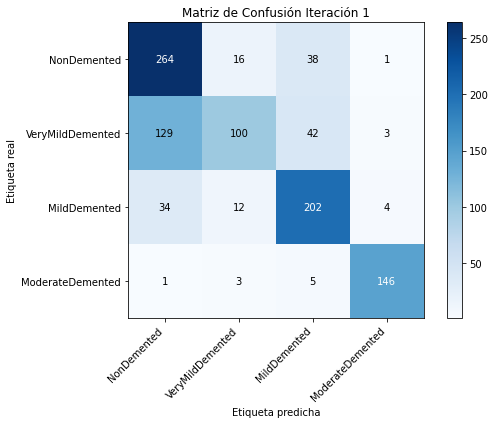

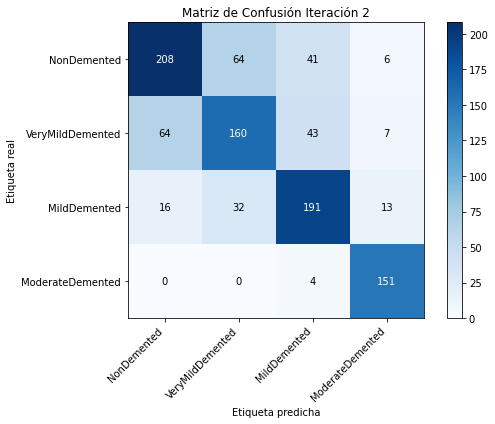

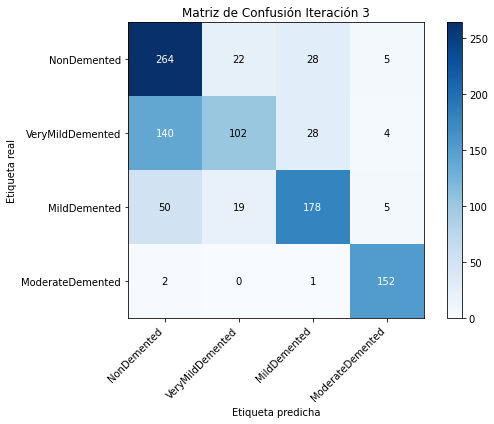

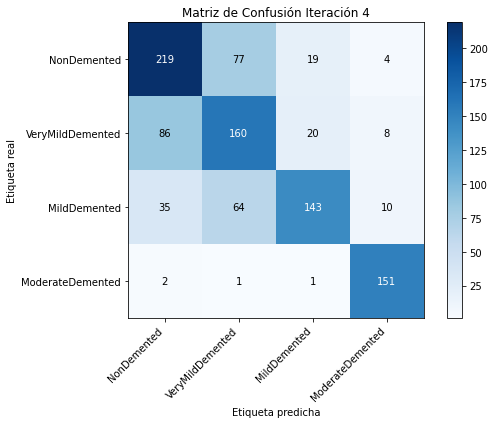

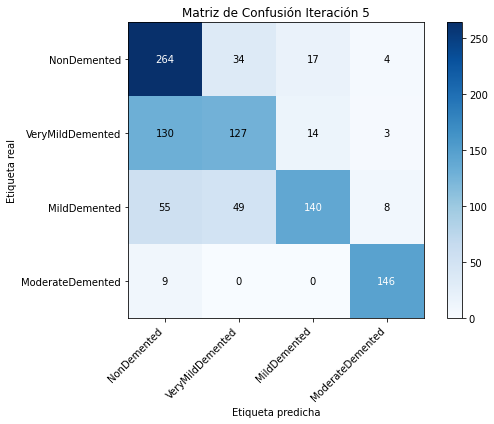

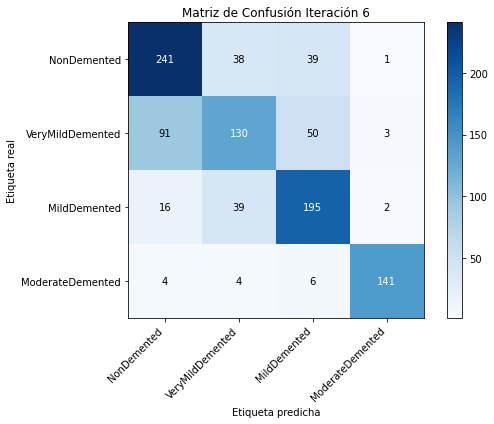

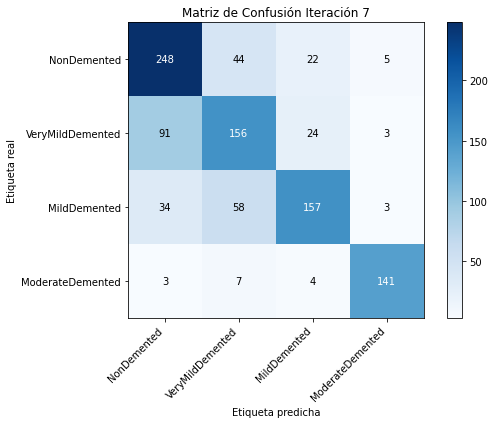

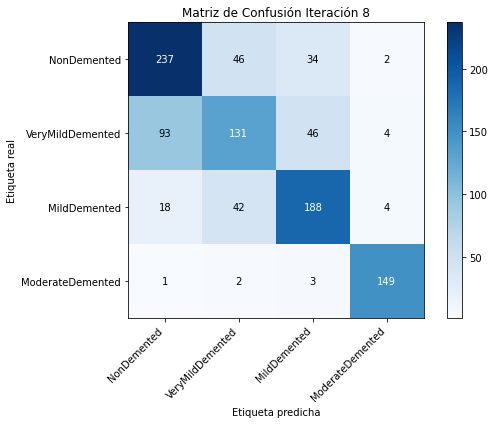

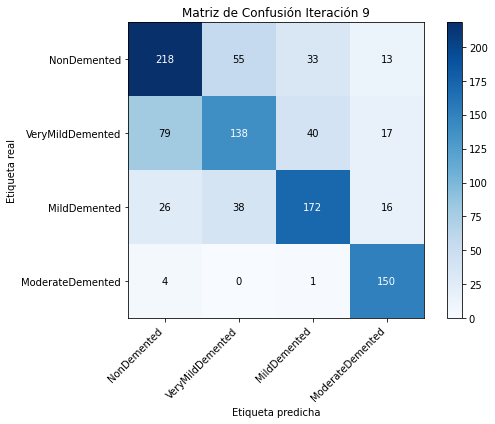

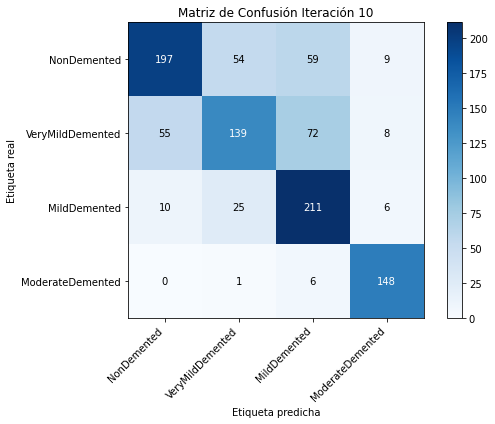

In [39]:
desired_order = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

indices = [data_noisy.labels.index(label) for label in desired_order]

def reorder_cm(cm, indices):
    cm = cm[indices, :]
    cm = cm[:, indices]
    return cm

def plot_confusion_matrix(cm, classes, title='Matriz de Confusión', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha='center', va='center',
                     color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')
    plt.tight_layout()
    plt.show()

for i, cm in enumerate(confusion_matrices, start=1):
    cm_ordered = reorder_cm(cm, indices)
    plot_confusion_matrix(cm_ordered, desired_order, title=f'Matriz de Confusión Iteración {i}')

### EfficientNetB0

In [ ]:
accuracy_efficientnet = []
f1_score_efficientnet = []
recall_efficientnet = []
precision_efficientnet = []

for i in range(1,n_it+1):
    print('It:', str(i), datetime.now())
    model_efficientnet = tf.keras.applications.EfficientNetB0(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_efficientnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_efficientnet.fit(np.array(data_noisy.X_train), np.array(data_noisy.y_train), epochs=epochs, batch_size=batch_size,
                        validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_efficientnet.predict(np.array(data_noisy.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data_noisy.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_efficientnet.append(report['accuracy'])
    f1_score_efficientnet.append(report['macro avg']['f1-score'])
    recall_efficientnet.append(report['macro avg']['recall'])
    precision_efficientnet.append(report['macro avg']['precision'])
    
    model_path = f'{base_path}/EfficientNetB0/EfficientNetB0_{i}.h5'
    model_efficientnet.save(model_path)
    print(f'Modelo guardado en: {model_path}')

In [33]:
model_dir = os.path.join(base_path, 'EfficientNetB0')

accuracy_efficientnet = []
f1_score_efficientnet = []
recall_efficientnet = []
precision_efficientnet = []

for i in range(1, n_it + 1):
    model_path = os.path.join(model_dir, f'EfficientNetB0_{i}.h5')

    model_efficientnet = tf.keras.models.load_model(model_path)

    y_pred = np.argmax(model_efficientnet.predict(np.array(data_noisy.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data_noisy.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_efficientnet.append(report['accuracy'])
    f1_score_efficientnet.append(report['macro avg']['f1-score'])
    recall_efficientnet.append(report['macro avg']['recall'])
    precision_efficientnet.append(report['macro avg']['precision'])

In [23]:
print("-"*5, 'EfficientNetB0', "-"*5)
print("accuracy: " + str(np.mean(accuracy_efficientnet)))
print("f1_score: " + str(np.mean(f1_score_efficientnet)))
print("recall: " + str(np.mean(recall_efficientnet)))
print("precision: " + str(np.mean(precision_efficientnet)))

----- EfficientNetB0 -----
accuracy: 0.6740999999999999
f1_score: 0.6820347241166368
recall: 0.6855291653733454
precision: 0.7240566283565263


### DenseNet201

In [ ]:
accuracy_densenet = []
f1_score_densenet = []
recall_densenet = []
precision_densenet = []

for i in range(1,n_it+1):
    print('It:', str(i), datetime.now())
    model_densenet = tf.keras.applications.DenseNet201(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_densenet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_densenet.fit(np.array(data_noisy.X_train), np.array(data_noisy.y_train), epochs=epochs, batch_size=batch_size,
                        validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_densenet.predict(np.array(data_noisy.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data_noisy.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_densenet.append(report['accuracy'])
    f1_score_densenet.append(report['macro avg']['f1-score'])
    recall_densenet.append(report['macro avg']['recall'])
    precision_densenet.append(report['macro avg']['precision'])
    
    model_path = f'{base_path}/DenseNet201/DenseNet201_{i}.h5'
    model_densenet.save(model_path)
    print(f'Modelo guardado en: {model_path}')

In [34]:
model_dir = os.path.join(base_path, 'DenseNet201')

accuracy_densenet = []
f1_score_densenet = []
recall_densenet = []
precision_densenet = []

for i in range(1, n_it + 1):
    model_path = os.path.join(model_dir, f'DenseNet201_{i}.h5')

    model_densenet = tf.keras.models.load_model(model_path)

    y_pred = np.argmax(model_densenet.predict(np.array(data_noisy.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data_noisy.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_densenet.append(report['accuracy'])
    f1_score_densenet.append(report['macro avg']['f1-score'])
    recall_densenet.append(report['macro avg']['recall'])
    precision_densenet.append(report['macro avg']['precision'])

In [27]:
print("-"*5, 'DenseNet201', "-"*5)
print("accuracy: " + str(np.mean(accuracy_densenet)))
print("f1_score: " + str(np.mean(f1_score_densenet)))
print("recall: " + str(np.mean(recall_densenet)))
print("precision: " + str(np.mean(precision_densenet)))

----- DenseNet201 -----
accuracy: 0.6703
f1_score: 0.66475970623199
recall: 0.6953532278620577
precision: 0.7922878747499918


### VGG19

In [ ]:
accuracy_vgg19 = []
f1_score_vgg19 = []
recall_vgg19 = []
precision_vgg19 = []

for i in range(1,n_it+1):
    print('It:', str(i), datetime.now())
    model_vgg19 = tf.keras.applications.VGG19(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_vgg19.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_vgg19.fit(np.array(data_noisy.X_train), np.array(data_noisy.y_train), epochs=epochs, batch_size=batch_size,
                        validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_vgg19.predict(np.array(data_noisy.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data_noisy.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_vgg19.append(report['accuracy'])
    f1_score_vgg19.append(report['macro avg']['f1-score'])
    recall_vgg19.append(report['macro avg']['recall'])
    precision_vgg19.append(report['macro avg']['precision'])
    
    model_path = f'{base_path}/VGG19/VGG19_{i}.h5'
    model_vgg19.save(model_path)
    print(f'Modelo guardado en: {model_path}')

In [ ]:
model_dir = os.path.join(base_path, 'VGG19')

accuracy_vgg19 = []
f1_score_vgg19 = []
recall_vgg19 = []
precision_vgg19 = []

for i in range(1, n_it + 1):
    model_path = os.path.join(model_dir, f'VGG19_{i}.h5')

    model_vgg = tf.keras.models.load_model(model_path)

    y_pred = np.argmax(model_vgg.predict(np.array(data_noisy.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data_noisy.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_vgg19.append(report['accuracy'])
    f1_score_vgg19.append(report['macro avg']['f1-score'])
    recall_vgg19.append(report['macro avg']['recall'])
    precision_vgg19.append(report['macro avg']['precision'])

In [31]:
print("-"*5, 'VGG19', "-"*5)
print("accuracy: " + str(np.mean(accuracy_vgg19)))
print("f1_score: " + str(np.mean(f1_score_vgg19)))
print("recall: " + str(np.mean(recall_vgg19)))
print("precision: " + str(np.mean(precision_vgg19)))

----- VGG19 -----
accuracy: 0.319
f1_score: 0.1209249431387415
recall: 0.25
precision: 0.07975


### ResNet50

In [ ]:
accuracy_resnet = []
f1_score_resnet = []
recall_resnet = []
precision_resnet = []

for i in range(1, n_it + 1):
    print('It:', str(i), datetime.now())
    model_resnet = tf.keras.applications.ResNet50(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_resnet.fit(np.array(data_noisy.X_train), np.array(data_noisy.y_train), 
                               epochs=epochs, batch_size=batch_size,
                               validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_resnet.predict(np.array(data_noisy.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data_noisy.y_val[:n_imgs], axis=1)
    
    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_resnet.append(report['accuracy'])
    f1_score_resnet.append(report['macro avg']['f1-score'])
    recall_resnet.append(report['macro avg']['recall'])
    precision_resnet.append(report['macro avg']['precision'])

    model_path = f'{base_path}/ResNet50/ResNet50_{i}.h5'
    model_resnet.save(model_path)
    print(f'Modelo guardado en: {model_path}')

In [36]:
model_dir = os.path.join(base_path, 'ResNet50')

accuracy_resnet = []
f1_score_resnet = []
recall_resnet = []
precision_resnet = []

for i in range(1, n_it + 1):
    model_path = os.path.join(model_dir, f'ResNet50_{i}.h5')
    
    model_resnet = tf.keras.models.load_model(model_path)

    y_pred = np.argmax(model_resnet.predict(np.array(data_noisy.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data_noisy.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_resnet.append(report['accuracy'])
    f1_score_resnet.append(report['macro avg']['f1-score'])
    recall_resnet.append(report['macro avg']['recall'])
    precision_resnet.append(report['macro avg']['precision'])

In [33]:
print("-"*5, 'ResNet50', "-"*5)
print("accuracy: " + str(np.mean(accuracy_resnet)))
print("f1_score: " + str(np.mean(f1_score_resnet)))
print("recall: " + str(np.mean(recall_resnet)))
print("precision: " + str(np.mean(precision_resnet)))

----- ResNet50 -----
accuracy: 0.6886
f1_score: 0.7060485158413919
recall: 0.7084303035885796
precision: 0.7911130317845931


### Summary of the results

In [37]:
df = pd.DataFrame(index=['Classifier', 'MOCVAE', 'EfficientNetB0', 'DenseNet201', 'VGG19', 'ResNet50'],
                  columns=['accuracy', 'f1-score', 'recall', 'precision'])

df.at['Classifier', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_classifier)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_classifier))
df.at['MOCVAE', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_mocvae))
df.at['EfficientNetB0', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_efficientnet))
df.at['DenseNet201', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_densenet)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_densenet))
df.at['VGG19', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_vgg19))
df.at['ResNet50', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_resnet)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_resnet))

df.at['Classifier', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_classifier)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_classifier))
df.at['MOCVAE', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_mocvae))
df.at['EfficientNetB0', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_efficientnet))
df.at['DenseNet201', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_densenet)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_densenet))
df.at['VGG19', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_vgg19))
df.at['ResNet50', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_resnet)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_resnet))

df.at['Classifier', 'recall'] = "{:.2f}".format(np.mean(recall_classifier)) + '$\pm$' + "{:.2f}".format(np.std(recall_classifier))
df.at['MOCVAE', 'recall'] = "{:.2f}".format(np.mean(recall_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(recall_mocvae))
df.at['EfficientNetB0', 'recall'] = "{:.2f}".format(np.mean(recall_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(recall_efficientnet))
df.at['DenseNet201', 'recall'] = "{:.2f}".format(np.mean(recall_densenet)) + '$\pm$' + "{:.2f}".format(np.std(recall_densenet))
df.at['VGG19', 'recall'] = "{:.2f}".format(np.mean(recall_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(recall_vgg19))
df.at['ResNet50', 'recall'] = "{:.2f}".format(np.mean(recall_resnet)) + '$\pm$' + "{:.2f}".format(np.std(recall_resnet))

df.at['Classifier', 'precision'] = "{:.2f}".format(np.mean(precision_classifier)) + '$\pm$' + "{:.2f}".format(np.std(precision_classifier))
df.at['MOCVAE', 'precision'] = "{:.2f}".format(np.mean(precision_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(precision_mocvae))
df.at['EfficientNetB0', 'precision'] = "{:.2f}".format(np.mean(precision_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(precision_efficientnet))
df.at['DenseNet201', 'precision'] = "{:.2f}".format(np.mean(precision_densenet)) + '$\pm$' + "{:.2f}".format(np.std(precision_densenet))
df.at['VGG19', 'precision'] = "{:.2f}".format(np.mean(precision_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(precision_vgg19))
df.at['ResNet50', 'precision'] = "{:.2f}".format(np.mean(precision_resnet)) + '$\pm$' + "{:.2f}".format(np.std(precision_resnet))

In [38]:
pd.set_option('display.max_colwidth', None)
df

,accuracy,f1-score,recall,precision
Classifier,0.71$\pm$0.09,0.72$\pm$0.10,0.73$\pm$0.10,0.76$\pm$0.04
MOCVAE,0.70$\pm$0.01,0.72$\pm$0.01,0.72$\pm$0.01,0.73$\pm$0.02
EfficientNetB0,0.67$\pm$0.05,0.68$\pm$0.06,0.69$\pm$0.06,0.72$\pm$0.03
DenseNet201,0.67$\pm$0.09,0.66$\pm$0.11,0.70$\pm$0.10,0.79$\pm$0.04
VGG19,0.32$\pm$0.00,0.12$\pm$0.00,0.25$\pm$0.00,0.08$\pm$0.00
ResNet50,0.69$\pm$0.07,0.71$\pm$0.07,0.71$\pm$0.07,0.79$\pm$0.03


In [41]:
from tabulate import tabulate

print(tabulate(df, tablefmt="latex_raw"))

\begin{tabular}{lllll}
\hline
 Classifier     & 0.71$\pm$0.09 & 0.72$\pm$0.10 & 0.73$\pm$0.10 & 0.76$\pm$0.04 \\
 MOCVAE         & 0.69$\pm$0.02 & 0.71$\pm$0.02 & 0.72$\pm$0.02 & 0.72$\pm$0.02 \\
 EfficientNetB0 & 0.67$\pm$0.05 & 0.68$\pm$0.06 & 0.69$\pm$0.06 & 0.72$\pm$0.03 \\
 DenseNet201    & 0.67$\pm$0.09 & 0.66$\pm$0.11 & 0.70$\pm$0.10 & 0.79$\pm$0.04 \\
 VGG19          & 0.32$\pm$0.00 & 0.12$\pm$0.00 & 0.25$\pm$0.00 & 0.08$\pm$0.00 \\
 ResNet50       & 0.69$\pm$0.07 & 0.71$\pm$0.07 & 0.71$\pm$0.07 & 0.79$\pm$0.03 \\
\hline
\end{tabular}


### Wilcoxon rank-sum Classifier

In [42]:
from scipy.stats import ranksums

In [43]:
print("\n-----Accuracy-----\n")

stat, p_value = ranksums(accuracy_classifier, accuracy_efficientnet)
print(f"Classifier - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_classifier, accuracy_densenet)
print(f"Classifier - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_classifier, accuracy_vgg19)
print(f"Classifier - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_classifier, accuracy_resnet)
print(f"Classifier - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----F1 score-----\n")

stat, p_value = ranksums(f1_score_classifier, f1_score_efficientnet)
print(f"Classifier - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_classifier, f1_score_densenet)
print(f"Classifier - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_classifier, f1_score_vgg19)
print(f"Classifier - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_classifier, f1_score_resnet)
print(f"Classifier - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Recall-----\n")

stat, p_value = ranksums(recall_classifier, recall_efficientnet)
print(f"Classifier - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_classifier, recall_densenet)
print(f"Classifier - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_classifier, recall_vgg19)
print(f"Classifier - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_classifier, recall_resnet)
print(f"Classifier - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Precision-----\n")

stat, p_value = ranksums(precision_classifier, precision_efficientnet)
print(f"Classifier - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_classifier, precision_densenet)
print(f"Classifier - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_classifier, precision_vgg19)
print(f"Classifier - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_classifier, precision_resnet)
print(f"Classifier - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")


-----Accuracy-----

Classifier - EfficientNetB0: statistic=1.4363, p-value=0.1509
Classifier - DenseNet201: statistic=1.3607, p-value=0.1736
Classifier - VGG19: statistic=3.7796, p-value=0.0002
Classifier - ResNet50: statistic=0.9827, p-value=0.3258

-----F1 score-----

Classifier - EfficientNetB0: statistic=1.5875, p-value=0.1124
Classifier - DenseNet201: statistic=1.2095, p-value=0.2265
Classifier - VGG19: statistic=3.7796, p-value=0.0002
Classifier - ResNet50: statistic=0.8315, p-value=0.4057

-----Recall-----

Classifier - EfficientNetB0: statistic=2.0410, p-value=0.0413
Classifier - DenseNet201: statistic=1.1339, p-value=0.2568
Classifier - VGG19: statistic=3.7796, p-value=0.0002
Classifier - ResNet50: statistic=1.2851, p-value=0.1988

-----Precision-----

Classifier - EfficientNetB0: statistic=1.5875, p-value=0.1124
Classifier - DenseNet201: statistic=-1.8898, p-value=0.0588
Classifier - VGG19: statistic=3.7796, p-value=0.0002
Classifier - ResNet50: statistic=-2.1922, p-value=0.

### Wilcoxon rank-sum MOCVAE

In [44]:
print("\n-----Accuracy-----\n")

stat, p_value = ranksums(accuracy_mocvae, accuracy_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_mocvae, accuracy_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_mocvae, accuracy_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_mocvae, accuracy_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----F1 score-----\n")

stat, p_value = ranksums(f1_score_mocvae, f1_score_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_mocvae, f1_score_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_mocvae, f1_score_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_mocvae, f1_score_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Recall-----\n")

stat, p_value = ranksums(recall_mocvae, recall_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_mocvae, recall_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_mocvae, recall_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_mocvae, recall_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Precision-----\n")

stat, p_value = ranksums(precision_mocvae, precision_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_mocvae, precision_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_mocvae, precision_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_mocvae, precision_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")


-----Accuracy-----

MOCVAE - EfficientNetB0: statistic=-0.2646, p-value=0.7913
MOCVAE - DenseNet201: statistic=1.1717, p-value=0.2413
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=0.7559, p-value=0.4497

-----F1 score-----

MOCVAE - EfficientNetB0: statistic=0.3024, p-value=0.7624
MOCVAE - DenseNet201: statistic=1.0583, p-value=0.2899
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=0.6803, p-value=0.4963

-----Recall-----

MOCVAE - EfficientNetB0: statistic=0.9071, p-value=0.3643
MOCVAE - DenseNet201: statistic=0.0000, p-value=1.0000
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=0.6803, p-value=0.4963

-----Precision-----

MOCVAE - EfficientNetB0: statistic=-0.3024, p-value=0.7624
MOCVAE - DenseNet201: statistic=-3.0993, p-value=0.0019
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=-3.7796, p-value=0.0002


### All values

In [45]:
#Security values
model_names = ['Classifier', 'MOCVAE', 'EfficientNetB0', 'DenseNet201', 'VGG19', 'ResNet50']

print("\n-----Accuracies-----\n")
for i, acc in enumerate([accuracy_classifier, accuracy_mocvae, accuracy_efficientnet, accuracy_densenet, accuracy_vgg19, accuracy_resnet]):
    print(model_names[i])
    print(acc)

print("\n-----f1-scores-----\n")
for i, f1 in enumerate([f1_score_classifier, f1_score_mocvae, f1_score_efficientnet, f1_score_densenet, f1_score_vgg19, f1_score_resnet]):
    print(model_names[i])
    print(f1)

print("\n-----Recall-----\n")
for i, rec in enumerate([recall_classifier, recall_mocvae, recall_efficientnet, recall_densenet, recall_vgg19, recall_resnet]):
    print(model_names[i])
    print(rec)

print("\n-----Precisions-----\n")
for i, pre in enumerate([precision_classifier, precision_mocvae, precision_efficientnet, precision_densenet, precision_vgg19, precision_resnet]):
    print(model_names[i])
    print(pre)


-----Accuracies-----

Classifier
[0.491, 0.811, 0.692, 0.782, 0.605, 0.778, 0.721, 0.7, 0.748, 0.765]
MOCVAE
[0.682, 0.737, 0.7, 0.664, 0.685, 0.695, 0.687, 0.701, 0.692, 0.699]
EfficientNetB0
[0.723, 0.713, 0.554, 0.697, 0.712, 0.702, 0.713, 0.608, 0.685, 0.634]
DenseNet201
[0.829, 0.482, 0.669, 0.679, 0.634, 0.662, 0.777, 0.57, 0.714, 0.687]
VGG19
[0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319]
ResNet50
[0.747, 0.63, 0.814, 0.663, 0.722, 0.756, 0.647, 0.657, 0.67, 0.58]

-----f1-scores-----

Classifier
[0.4597577146004527, 0.8251113663595879, 0.699205671175029, 0.7947718773413883, 0.5977827468609179, 0.7783007820434236, 0.72995991533864, 0.7272556127696022, 0.7559003517610258, 0.7838521261604645]
MOCVAE
[0.6924686098851707, 0.7557485742756921, 0.715528446738182, 0.6899742462025639, 0.7048793095709825, 0.7126177324912726, 0.710980487922609, 0.7181412635183893, 0.7046654356706785, 0.7179497865462774]
EfficientNetB0
[0.7357506863191752, 0.7115366281900242, 0.5489

## Results with 10 iterations label variation 50%

In [33]:
base_path = '/workspace/Alzheimer/MOCAE_Base-master/results_training_labelvariation_50/'

### Classifier

In [ ]:
tf.get_logger().setLevel('ERROR')  

accuracy_classifier = []
f1_score_classifier = []
recall_classifier = []
precision_classifier = []

for i in range(1, n_it + 1):
    model_path = os.path.join(base_path, f'Classifier_{i}', 'models/')

    encoder = load_model(os.path.join(model_path, 'e_best_encoder.h5'), custom_objects={'sampling': sampling})
    classifier = load_model(os.path.join(model_path, 'e_best_classifier.h5'), custom_objects={'sampling': sampling})

    lat_space = encoder.predict(data_noisy.X_val[:n_imgs])

    y_real = data_noisy.y_val[:n_imgs]
    if len(y_real.shape) > 1:
        y_real = np.argmax(y_real, axis=1)

    y_pred = classifier.predict(lat_space)
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)

    report = classification_report(y_real, y_pred, output_dict=True)
    accuracy_classifier.append(report['accuracy'])
    f1_score_classifier.append(report['macro avg']['f1-score'])
    recall_classifier.append(report['macro avg']['recall'])
    precision_classifier.append(report['macro avg']['precision'])

In [47]:
print("-"*5, 'Classifier', "-"*5)
print("accuracy: " + str(np.mean(accuracy_classifier)))
print("f1_score: " + str(np.mean(f1_score_classifier)))
print("recall: " + str(np.mean(recall_classifier)))
print("precision: " + str(np.mean(precision_classifier)))

----- Classifier -----
accuracy: 0.5210999999999999
f1_score: 0.5033700815441459
recall: 0.5507402416797487
precision: 0.5727872594239656


### MOCVAE

In [34]:
tf.get_logger().setLevel('ERROR')  

accuracy_mocvae = []
f1_score_mocvae = []
recall_mocvae = []
precision_mocvae = []

confusion_matrices = []

for i in range(1, n_it + 1):
    model_path = os.path.join(base_path, f'MOCVAE_{i}', 'models/')

    encoder = load_model(model_path + 'e_best_encoder.h5', custom_objects={'sampling': sampling})
    classifier = load_model(model_path + 'e_best_classifier.h5', custom_objects={'sampling': sampling})

    lat_space = encoder.predict(data_noisy.X_val[:n_imgs])
    z_mean, z_log_sigma, z = lat_space
    lat_space = z  

    y_real = data_noisy.y_val[:n_imgs]
    if len(y_real.shape) > 1:
        y_real = np.argmax(y_real, axis=1)

    y_pred = classifier.predict(lat_space)
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)

    report = classification_report(y_real, y_pred, output_dict=True)
    accuracy_mocvae.append(report['accuracy'])
    f1_score_mocvae.append(report['macro avg']['f1-score'])
    recall_mocvae.append(report['macro avg']['recall'])
    precision_mocvae.append(report['macro avg']['precision'])
    
    cm = confusion_matrix(y_real, y_pred)
    confusion_matrices.append(cm)

In [33]:
print("-"*5, 'MOCVAE', "-"*5)
print("accuracy: " + str(np.mean(accuracy_mocvae)))
print("f1_score: " + str(np.mean(f1_score_mocvae)))
print("recall: " + str(np.mean(recall_mocvae)))
print("precision: " + str(np.mean(precision_mocvae)))

----- MOCVAE -----
accuracy: 0.5963
f1_score: 0.6039743178074461
recall: 0.6233376362369142
precision: 0.6109782479116806


In [35]:
path = '/workspace/Alzheimer/MOCAE_Base-master/confusion_matrix_50'
os.makedirs(path, exist_ok=True) 

desired_order = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
indices = [data.labels.index(label) for label in desired_order]

def reorder_cm(cm, indices):
    cm = cm[indices, :]
    cm = cm[:, indices]
    return cm

def plot_confusion_matrix(cm, classes, title='Matriz de Confusión', cmap=plt.cm.Blues, filename=None):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha='center', va='center',
                     color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

total = len(confusion_matrices)
random_indices = random.sample(range(total), 4)
for idx in random_indices:
    cm = confusion_matrices[idx]
    cm_ordered = reorder_cm(cm, indices)
    iteracion = idx + 1  
    filename = os.path.join(path, f'confusion_matrix_iteracion_{iteracion}.png')
    plot_confusion_matrix(
        cm_ordered,
        desired_order,
        title=f'Matriz de Confusión Iteración {iteracion}',
        filename=filename
    )

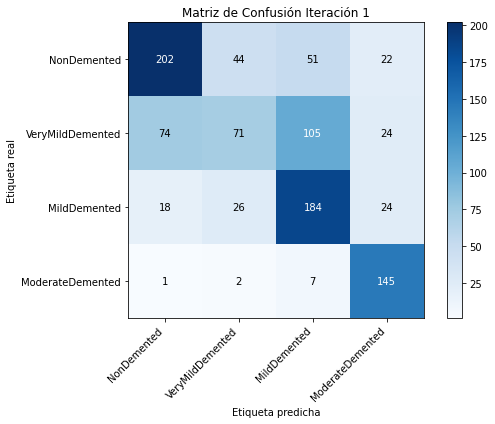

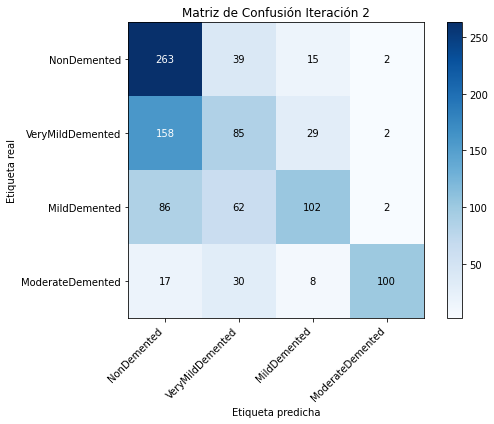

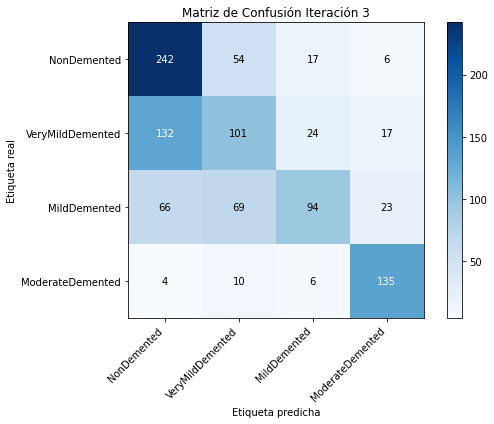

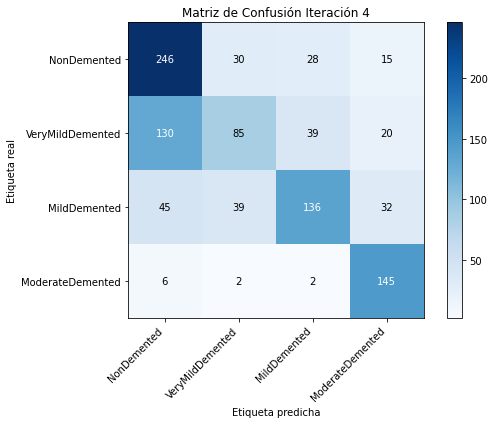

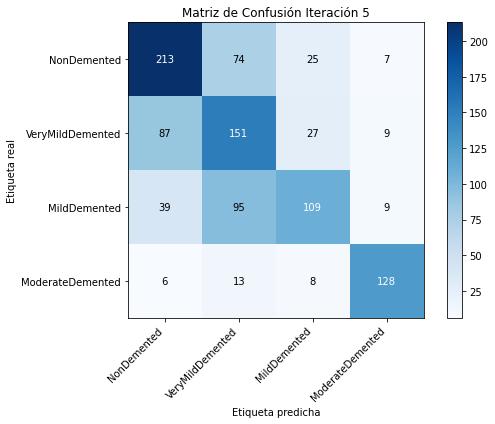

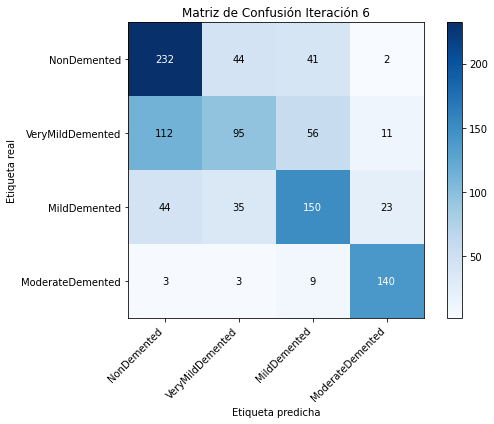

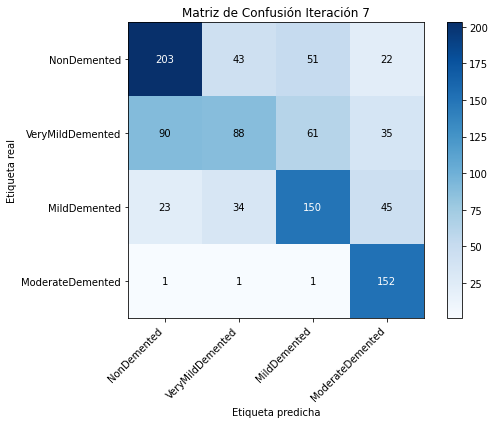

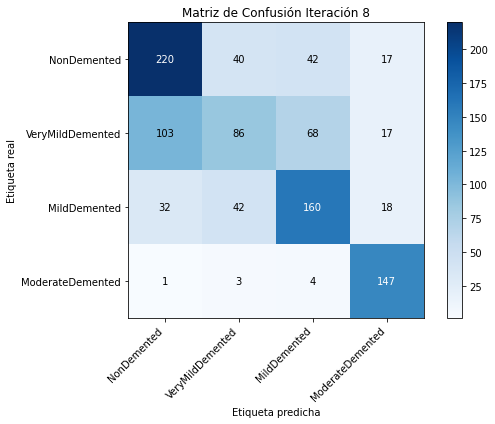

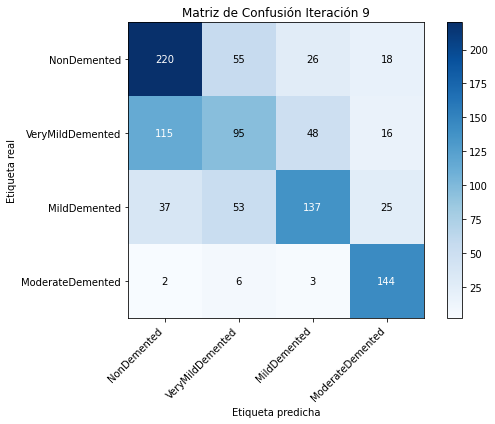

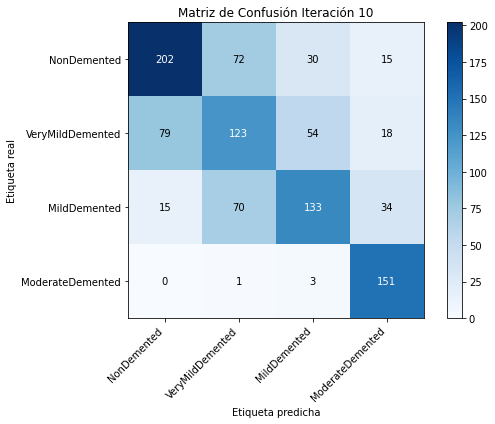

In [44]:
desired_order = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

indices = [data.labels.index(label) for label in desired_order]

def reorder_cm(cm, indices):
    cm = cm[indices, :]
    cm = cm[:, indices]
    return cm

def plot_confusion_matrix(cm, classes, title='Matriz de Confusión', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha='center', va='center',
                     color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')
    plt.tight_layout()
    plt.show()

for i, cm in enumerate(confusion_matrices, start=1):
    cm_ordered = reorder_cm(cm, indices)
    plot_confusion_matrix(cm_ordered, desired_order, title=f'Matriz de Confusión Iteración {i}')

### EfficientNetB0

In [ ]:
accuracy_efficientnet = []
f1_score_efficientnet = []
recall_efficientnet = []
precision_efficientnet = []

for i in range(1,n_it+1):
    print('It:', str(i), datetime.now())
    model_efficientnet = tf.keras.applications.EfficientNetB0(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_efficientnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_efficientnet.fit(np.array(data_noisy.X_train), np.array(data_noisy.y_train), epochs=epochs, batch_size=batch_size,
                        validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_efficientnet.predict(np.array(data_noisy.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data_noisy.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_efficientnet.append(report['accuracy'])
    f1_score_efficientnet.append(report['macro avg']['f1-score'])
    recall_efficientnet.append(report['macro avg']['recall'])
    precision_efficientnet.append(report['macro avg']['precision'])
    
    model_path = f'{base_path}/EfficientNetB0/EfficientNetB0_{i}.h5'
    model_efficientnet.save(model_path)
    print(f'Modelo guardado en: {model_path}')

In [49]:
model_dir = os.path.join(base_path, 'EfficientNetB0')

accuracy_efficientnet = []
f1_score_efficientnet = []
recall_efficientnet = []
precision_efficientnet = []

for i in range(1, n_it + 1):
    model_path = os.path.join(model_dir, f'EfficientNetB0_{i}.h5')

    model_efficientnet = tf.keras.models.load_model(model_path)

    y_pred = np.argmax(model_efficientnet.predict(np.array(data_noisy.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data_noisy.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_efficientnet.append(report['accuracy'])
    f1_score_efficientnet.append(report['macro avg']['f1-score'])
    recall_efficientnet.append(report['macro avg']['recall'])
    precision_efficientnet.append(report['macro avg']['precision'])

In [27]:
print("-"*5, 'EfficientNetB0', "-"*5)
print("accuracy: " + str(np.mean(accuracy_efficientnet)))
print("f1_score: " + str(np.mean(f1_score_efficientnet)))
print("recall: " + str(np.mean(recall_efficientnet)))
print("precision: " + str(np.mean(precision_efficientnet)))

----- EfficientNetB0 -----
accuracy: 0.5111
f1_score: 0.5039156392776092
recall: 0.5286381405727314
precision: 0.5462311193996296


### DenseNet201

In [ ]:
accuracy_densenet = []
f1_score_densenet = []
recall_densenet = []
precision_densenet = []

for i in range(1,n_it+1):
    print('It:', str(i), datetime.now())
    model_densenet = tf.keras.applications.DenseNet201(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_densenet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_densenet.fit(np.array(data_noisy.X_train), np.array(data_noisy.y_train), epochs=epochs, batch_size=batch_size,
                        validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_densenet.predict(np.array(data_noisy.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data_noisy.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_densenet.append(report['accuracy'])
    f1_score_densenet.append(report['macro avg']['f1-score'])
    recall_densenet.append(report['macro avg']['recall'])
    precision_densenet.append(report['macro avg']['precision'])
    
    model_path = f'{base_path}/DenseNet201/DenseNet201_{i}.h5'
    model_densenet.save(model_path)
    print(f'Modelo guardado en: {model_path}')

In [50]:
model_dir = os.path.join(base_path, 'DenseNet201')

accuracy_densenet = []
f1_score_densenet = []
recall_densenet = []
precision_densenet = []

for i in range(1, n_it + 1):
    model_path = os.path.join(model_dir, f'DenseNet201_{i}.h5')

    model_densenet = tf.keras.models.load_model(model_path)

    y_pred = np.argmax(model_densenet.predict(np.array(data_noisy.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data_noisy.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_densenet.append(report['accuracy'])
    f1_score_densenet.append(report['macro avg']['f1-score'])
    recall_densenet.append(report['macro avg']['recall'])
    precision_densenet.append(report['macro avg']['precision'])

In [26]:
print("-"*5, 'DenseNet201', "-"*5)
print("accuracy: " + str(np.mean(accuracy_densenet)))
print("f1_score: " + str(np.mean(f1_score_densenet)))
print("recall: " + str(np.mean(recall_densenet)))
print("precision: " + str(np.mean(precision_densenet)))

----- DenseNet201 -----
accuracy: 0.4689
f1_score: 0.4462746916762922
recall: 0.5073141230419796
precision: 0.5301216043531697


### VGG19

In [ ]:
accuracy_vgg19 = []
f1_score_vgg19 = []
recall_vgg19 = []
precision_vgg19 = []

for i in range(1,n_it+1):
    print('It:', str(i), datetime.now())
    model_vgg19 = tf.keras.applications.VGG19(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_vgg19.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_vgg19.fit(np.array(data_noisy.X_train), np.array(data_noisy.y_train), epochs=epochs, batch_size=batch_size,
                        validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_vgg19.predict(np.array(data_noisy.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data_noisy.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_vgg19.append(report['accuracy'])
    f1_score_vgg19.append(report['macro avg']['f1-score'])
    recall_vgg19.append(report['macro avg']['recall'])
    precision_vgg19.append(report['macro avg']['precision'])
    
    model_path = f'{base_path}/VGG19/VGG19_{i}.h5'
    model_vgg19.save(model_path)
    print(f'Modelo guardado en: {model_path}')

In [ ]:
model_dir = os.path.join(base_path, 'VGG19')

accuracy_vgg19 = []
f1_score_vgg19 = []
recall_vgg19 = []
precision_vgg19 = []

for i in range(1, n_it + 1):
    model_path = os.path.join(model_dir, f'VGG19_{i}.h5')

    model_vgg = tf.keras.models.load_model(model_path)

    y_pred = np.argmax(model_vgg.predict(np.array(data_noisy.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data_noisy.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_vgg19.append(report['accuracy'])
    f1_score_vgg19.append(report['macro avg']['f1-score'])
    recall_vgg19.append(report['macro avg']['recall'])
    precision_vgg19.append(report['macro avg']['precision'])

In [22]:
print("-"*5, 'VGG19', "-"*5)
print("accuracy: " + str(np.mean(accuracy_vgg19)))
print("f1_score: " + str(np.mean(f1_score_vgg19)))
print("recall: " + str(np.mean(recall_vgg19)))
print("precision: " + str(np.mean(precision_vgg19)))

----- VGG19 -----
accuracy: 0.319
f1_score: 0.1209249431387415
recall: 0.25
precision: 0.07975


### ResNet50

In [ ]:
accuracy_resnet = []
f1_score_resnet = []
recall_resnet = []
precision_resnet = []

for i in range(1, n_it + 1):
    print('It:', str(i), datetime.now())
    model_resnet = tf.keras.applications.ResNet50(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_resnet.fit(np.array(data_noisy.X_train), np.array(data_noisy.y_train), 
                               epochs=epochs, batch_size=batch_size,
                               validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_resnet.predict(np.array(data_noisy.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data_noisy.y_val[:n_imgs], axis=1)
    
    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_resnet.append(report['accuracy'])
    f1_score_resnet.append(report['macro avg']['f1-score'])
    recall_resnet.append(report['macro avg']['recall'])
    precision_resnet.append(report['macro avg']['precision'])

    model_path = f'{base_path}/ResNet50/ResNet50_{i}.h5'
    model_resnet.save(model_path)
    print(f'Modelo guardado en: {model_path}')

In [ ]:
model_dir = os.path.join(base_path, 'ResNet50')

accuracy_resnet = []
f1_score_resnet = []
recall_resnet = []
precision_resnet = []

for i in range(1, n_it + 1):
    model_path = os.path.join(model_dir, f'ResNet50_{i}.h5')
    
    model_resnet = tf.keras.models.load_model(model_path)

    y_pred = np.argmax(model_resnet.predict(np.array(data_noisy.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data_noisy.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_resnet.append(report['accuracy'])
    f1_score_resnet.append(report['macro avg']['f1-score'])
    recall_resnet.append(report['macro avg']['recall'])
    precision_resnet.append(report['macro avg']['precision'])

In [25]:
print("-"*5, 'ResNet50', "-"*5)
print("accuracy: " + str(np.mean(accuracy_resnet)))
print("f1_score: " + str(np.mean(f1_score_resnet)))
print("recall: " + str(np.mean(recall_resnet)))
print("precision: " + str(np.mean(precision_resnet)))

----- ResNet50 -----
accuracy: 0.42350000000000004
f1_score: 0.36768424333120964
recall: 0.43842778667212545
precision: 0.4805930759661994


### Summary of the results

In [53]:
df = pd.DataFrame(index=['Classifier', 'MOCVAE', 'EfficientNetB0', 'DenseNet201', 'VGG19', 'ResNet50'],
                  columns=['accuracy', 'f1-score', 'recall', 'precision'])

df.at['Classifier', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_classifier)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_classifier))
df.at['MOCVAE', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_mocvae))
df.at['EfficientNetB0', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_efficientnet))
df.at['DenseNet201', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_densenet)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_densenet))
df.at['VGG19', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_vgg19))
df.at['ResNet50', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_resnet)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_resnet))

df.at['Classifier', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_classifier)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_classifier))
df.at['MOCVAE', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_mocvae))
df.at['EfficientNetB0', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_efficientnet))
df.at['DenseNet201', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_densenet)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_densenet))
df.at['VGG19', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_vgg19))
df.at['ResNet50', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_resnet)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_resnet))

df.at['Classifier', 'recall'] = "{:.2f}".format(np.mean(recall_classifier)) + '$\pm$' + "{:.2f}".format(np.std(recall_classifier))
df.at['MOCVAE', 'recall'] = "{:.2f}".format(np.mean(recall_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(recall_mocvae))
df.at['EfficientNetB0', 'recall'] = "{:.2f}".format(np.mean(recall_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(recall_efficientnet))
df.at['DenseNet201', 'recall'] = "{:.2f}".format(np.mean(recall_densenet)) + '$\pm$' + "{:.2f}".format(np.std(recall_densenet))
df.at['VGG19', 'recall'] = "{:.2f}".format(np.mean(recall_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(recall_vgg19))
df.at['ResNet50', 'recall'] = "{:.2f}".format(np.mean(recall_resnet)) + '$\pm$' + "{:.2f}".format(np.std(recall_resnet))

df.at['Classifier', 'precision'] = "{:.2f}".format(np.mean(precision_classifier)) + '$\pm$' + "{:.2f}".format(np.std(precision_classifier))
df.at['MOCVAE', 'precision'] = "{:.2f}".format(np.mean(precision_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(precision_mocvae))
df.at['EfficientNetB0', 'precision'] = "{:.2f}".format(np.mean(precision_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(precision_efficientnet))
df.at['DenseNet201', 'precision'] = "{:.2f}".format(np.mean(precision_densenet)) + '$\pm$' + "{:.2f}".format(np.std(precision_densenet))
df.at['VGG19', 'precision'] = "{:.2f}".format(np.mean(precision_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(precision_vgg19))
df.at['ResNet50', 'precision'] = "{:.2f}".format(np.mean(precision_resnet)) + '$\pm$' + "{:.2f}".format(np.std(precision_resnet))

In [54]:
pd.set_option('display.max_colwidth', None)
df

,accuracy,f1-score,recall,precision
Classifier,0.52$\pm$0.11,0.50$\pm$0.16,0.55$\pm$0.11,0.57$\pm$0.17
MOCVAE,0.60$\pm$0.02,0.61$\pm$0.02,0.63$\pm$0.03,0.61$\pm$0.02
EfficientNetB0,0.51$\pm$0.07,0.50$\pm$0.07,0.53$\pm$0.06,0.55$\pm$0.04
DenseNet201,0.47$\pm$0.12,0.45$\pm$0.13,0.51$\pm$0.11,0.53$\pm$0.11
VGG19,0.32$\pm$0.00,0.12$\pm$0.00,0.25$\pm$0.00,0.08$\pm$0.00
ResNet50,0.42$\pm$0.11,0.37$\pm$0.15,0.44$\pm$0.12,0.48$\pm$0.14


In [40]:
from tabulate import tabulate

print(tabulate(df, tablefmt="latex_raw"))

\begin{tabular}{lllll}
\hline
 Classifier     & 0.52$\pm$0.11 & 0.50$\pm$0.16 & 0.55$\pm$0.11 & 0.57$\pm$0.17 \\
 MOCVAE         & 0.60$\pm$0.02 & 0.60$\pm$0.02 & 0.62$\pm$0.03 & 0.61$\pm$0.02 \\
 EfficientNetB0 & 0.51$\pm$0.07 & 0.50$\pm$0.07 & 0.53$\pm$0.06 & 0.55$\pm$0.04 \\
 DenseNet201    & 0.47$\pm$0.12 & 0.45$\pm$0.13 & 0.51$\pm$0.11 & 0.53$\pm$0.11 \\
 VGG19          & 0.32$\pm$0.00 & 0.12$\pm$0.00 & 0.25$\pm$0.00 & 0.08$\pm$0.00 \\
 ResNet50       & 0.42$\pm$0.11 & 0.37$\pm$0.15 & 0.44$\pm$0.12 & 0.48$\pm$0.14 \\
\hline
\end{tabular}


### Wilcoxon rank-sum Classifier

In [41]:
from scipy.stats import ranksums

In [42]:
print("\n-----Accuracy-----\n")

stat, p_value = ranksums(accuracy_classifier, accuracy_efficientnet)
print(f"Classifier - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_classifier, accuracy_densenet)
print(f"Classifier - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_classifier, accuracy_vgg19)
print(f"Classifier - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_classifier, accuracy_resnet)
print(f"Classifier - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----F1 score-----\n")

stat, p_value = ranksums(f1_score_classifier, f1_score_efficientnet)
print(f"Classifier - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_classifier, f1_score_densenet)
print(f"Classifier - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_classifier, f1_score_vgg19)
print(f"Classifier - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_classifier, f1_score_resnet)
print(f"Classifier - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Recall-----\n")

stat, p_value = ranksums(recall_classifier, recall_efficientnet)
print(f"Classifier - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_classifier, recall_densenet)
print(f"Classifier - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_classifier, recall_vgg19)
print(f"Classifier - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_classifier, recall_resnet)
print(f"Classifier - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Precision-----\n")

stat, p_value = ranksums(precision_classifier, precision_efficientnet)
print(f"Classifier - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_classifier, precision_densenet)
print(f"Classifier - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_classifier, precision_vgg19)
print(f"Classifier - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_classifier, precision_resnet)
print(f"Classifier - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")


-----Accuracy-----

Classifier - EfficientNetB0: statistic=1.2095, p-value=0.2265
Classifier - DenseNet201: statistic=1.2095, p-value=0.2265
Classifier - VGG19: statistic=3.0237, p-value=0.0025
Classifier - ResNet50: statistic=2.0410, p-value=0.0413

-----F1 score-----

Classifier - EfficientNetB0: statistic=0.9827, p-value=0.3258
Classifier - DenseNet201: statistic=1.3607, p-value=0.1736
Classifier - VGG19: statistic=3.0237, p-value=0.0025
Classifier - ResNet50: statistic=2.1166, p-value=0.0343

-----Recall-----

Classifier - EfficientNetB0: statistic=1.4363, p-value=0.1509
Classifier - DenseNet201: statistic=1.2095, p-value=0.2265
Classifier - VGG19: statistic=3.4017, p-value=0.0007
Classifier - ResNet50: statistic=2.2678, p-value=0.0233

-----Precision-----

Classifier - EfficientNetB0: statistic=2.6458, p-value=0.0082
Classifier - DenseNet201: statistic=1.5119, p-value=0.1306
Classifier - VGG19: statistic=3.0237, p-value=0.0025
Classifier - ResNet50: statistic=2.3434, p-value=0.01

### Wilcoxon rank-sum MOCVAE

In [43]:
print("\n-----Accuracy-----\n")

stat, p_value = ranksums(accuracy_mocvae, accuracy_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_mocvae, accuracy_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_mocvae, accuracy_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_mocvae, accuracy_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----F1 score-----\n")

stat, p_value = ranksums(f1_score_mocvae, f1_score_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_mocvae, f1_score_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_mocvae, f1_score_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_mocvae, f1_score_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Recall-----\n")

stat, p_value = ranksums(recall_mocvae, recall_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_mocvae, recall_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_mocvae, recall_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_mocvae, recall_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Precision-----\n")

stat, p_value = ranksums(precision_mocvae, precision_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_mocvae, precision_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_mocvae, precision_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_mocvae, precision_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")


-----Accuracy-----

MOCVAE - EfficientNetB0: statistic=2.9481, p-value=0.0032
MOCVAE - DenseNet201: statistic=2.2678, p-value=0.0233
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=3.6285, p-value=0.0003

-----F1 score-----

MOCVAE - EfficientNetB0: statistic=3.3261, p-value=0.0009
MOCVAE - DenseNet201: statistic=2.7969, p-value=0.0052
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=3.6285, p-value=0.0003

-----Recall-----

MOCVAE - EfficientNetB0: statistic=3.1749, p-value=0.0015
MOCVAE - DenseNet201: statistic=2.1922, p-value=0.0284
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=3.5529, p-value=0.0004

-----Precision-----

MOCVAE - EfficientNetB0: statistic=3.4773, p-value=0.0005
MOCVAE - DenseNet201: statistic=2.1922, p-value=0.0284
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=2.1922, p-value=0.0284


### All values

In [44]:
#Security values
model_names = ['Classifier', 'MOCVAE', 'EfficientNetB0', 'DenseNet201', 'VGG19', 'ResNet50']

print("\n-----Accuracies-----\n")
for i, acc in enumerate([accuracy_classifier, accuracy_mocvae, accuracy_efficientnet, accuracy_densenet, accuracy_vgg19, accuracy_resnet]):
    print(model_names[i])
    print(acc)

print("\n-----f1-scores-----\n")
for i, f1 in enumerate([f1_score_classifier, f1_score_mocvae, f1_score_efficientnet, f1_score_densenet, f1_score_vgg19, f1_score_resnet]):
    print(model_names[i])
    print(f1)

print("\n-----Recall-----\n")
for i, rec in enumerate([recall_classifier, recall_mocvae, recall_efficientnet, recall_densenet, recall_vgg19, recall_resnet]):
    print(model_names[i])
    print(rec)

print("\n-----Precisions-----\n")
for i, pre in enumerate([precision_classifier, precision_mocvae, precision_efficientnet, precision_densenet, precision_vgg19, precision_resnet]):
    print(model_names[i])
    print(pre)


-----Accuracies-----

Classifier
[0.562, 0.508, 0.599, 0.61, 0.252, 0.574, 0.569, 0.405, 0.621, 0.511]
MOCVAE
[0.605, 0.55, 0.57, 0.621, 0.603, 0.608, 0.593, 0.606, 0.608, 0.599]
EfficientNetB0
[0.568, 0.501, 0.357, 0.496, 0.609, 0.519, 0.557, 0.463, 0.494, 0.547]
DenseNet201
[0.388, 0.41, 0.546, 0.699, 0.364, 0.312, 0.498, 0.467, 0.633, 0.372]
VGG19
[0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319]
ResNet50
[0.578, 0.249, 0.52, 0.334, 0.503, 0.403, 0.225, 0.467, 0.532, 0.424]

-----f1-scores-----

Classifier
[0.5848003949385056, 0.46928144867482585, 0.6149975470676107, 0.6124138330174097, 0.10063897763578275, 0.5923321013013791, 0.5834836096176822, 0.3407684225989502, 0.6435438964698315, 0.4914405841194819]
MOCVAE
[0.6026164851215476, 0.5626260154101377, 0.5783376129440668, 0.6211739189314947, 0.6266528577258006, 0.6165282298719158, 0.5875479925463668, 0.618634915085523, 0.6163116839325274, 0.6093134665050813]
EfficientNetB0
[0.5765403637942766, 0.470933500178611

## Gráfica de comparación F1-score según el % de variación

In [63]:
variaciones = ['0%', '30%', '50%']
f1_classifier = [0.90, 0.72, 0.50]
f1_mocvae = [0.82, 0.71, 0.60]
f1_efficientnet = [0.68, 0.68, 0.50]
f1_densenet = [0.66, 0.66, 0.45]
f1_vgg = [0.12, 0.12, 0.12]
f1_resnet = [0.71, 0.71, 0.37]

f1_data = {
    '% Variación': variaciones * 6,
    'F1-score': f1_mocvae + f1_classifier + f1_efficientnet + f1_densenet + f1_vgg + f1_resnet,
    'Modelo': (['MOCVAE'] * 3 + ['Classifier'] * 3 + ['EfficientNetB0'] * 3 +
               ['DenseNet201'] * 3 + ['VGG19'] * 3 + ['ResNet50'] * 3)
}

df = pd.DataFrame(f1_data)

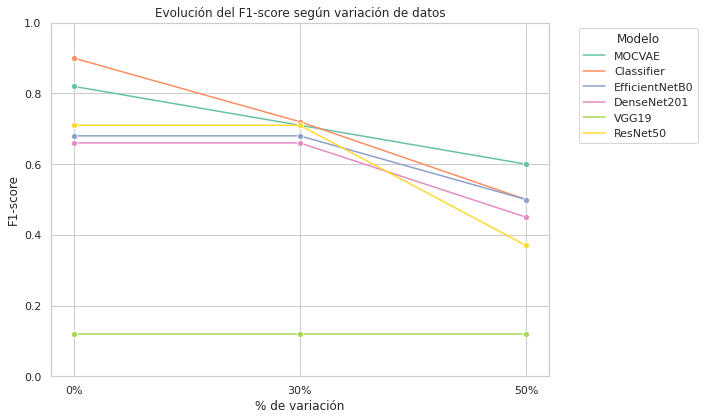

In [72]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='% Variación', y='F1-score', hue='Modelo', data=df, palette='Set2', marker='o')

plt.title('Evolución del F1-score según variación de datos')
plt.ylim(0, 1)
plt.ylabel('F1-score')
plt.xlabel('% de variación')
plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()